# 1. Daten Laden

In [25]:
# Bibliotheken laden
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dateien von Google Drive bereitstellen
from google.colab import drive
drive.mount('/content/drive')

# Excel auslesen
Datensatz = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Model Engineering/PSP_Jan_Feb_2019.xlsx',header = 0)
Datensatz = Datensatz.rename(columns = {"Unnamed: 0":"id"})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Modellentwicklung & -bewertung

In [38]:
# Bilbiotheken laden
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import  auc
from sklearn.metrics import  roc_curve
from sklearn.metrics import  precision_score

def auc_visualisierung(model,x_test,y_test):
  # Berechnung der Falsch-Positiv-Rate und der Wahr-Positiv-Rate für alle Schwellenwerte der Klassifizierung
  probs = model.predict_proba(x_test)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  # Visualisierung
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# Datenaufbereitung
label_encoder = LabelEncoder()

ML_Daten = Datensatz.filter(['amount','success','PSP','country','card','tmsp','3D_secured'], axis=1)

ML_Daten['country'] = label_encoder.fit_transform(ML_Daten['country'])
ML_Daten['PSP'] = label_encoder.fit_transform(ML_Daten['PSP'])
ML_Daten['card'] = label_encoder.fit_transform(ML_Daten['card'])

# Datumswerte in Tag/ Wochentag/ Stunde aufteilen
ML_Daten['weekday'] = ML_Daten['tmsp'].dt.day_name()
ML_Daten['weekday'] = label_encoder.fit_transform(ML_Daten['weekday'])
ML_Daten['day'] = ML_Daten['tmsp'].dt.strftime('%d').astype(int)
ML_Daten['hour'] = ML_Daten['tmsp'].dt.strftime('%H').astype(int)

# Separation in X Merkmale and Zielvariable Y
Y = ML_Daten['success']
X = ML_Daten.filter(['amount','PSP','3D_secured','card','country','weekday','day','hour'], axis=1)

# Aufteilung in Trainings- und Validierungsdatensatz
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## 2.1 RandomForest

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.79
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.81


Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84




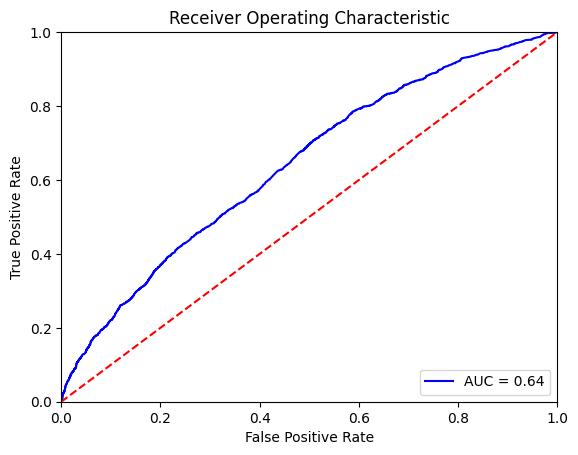

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  precision_score

rfc = RandomForestClassifier(max_depth = 2)
rfc.fit(x_train, y_train)

y_pred_proba = rfc.predict_proba(x_test)

print('Bewertungsmetriken')
print('#'*20)
print(f"Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {round(rfc.score(x_train, y_train),2)}")
print(f"Vorhersage-Genauigkeit auf Basis der Testdaten: {round(rfc.score(x_test, y_test),2)}")
print('\n')
precision_train = round(precision_score(y_train,rfc.predict(x_train),zero_division=1.0,average='weighted'),2)
precision_test = round(precision_score(y_test,rfc.predict(x_test),zero_division=1.0,average='weighted'),2)
print(f"Precision auf Basis der Trainingsdaten: {precision_train}")
print(f"Precision auf Basis der Testdaten: {precision_test}")
print('\n')
auc_visualisierung(rfc,x_test,y_test)

## 2.2 Logistische Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bewertungsmetriken
####################
Bewertung der Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.79
Bewertung der Vorhersage-Genauigkeit auf Basis der Testdaten: 0.81


Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84




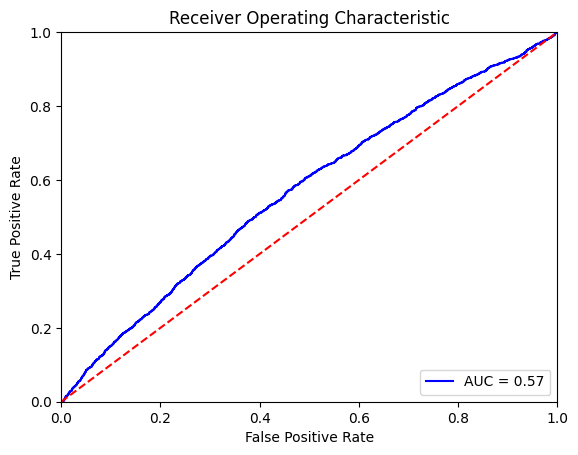

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

x_train_scaled = preprocessing.StandardScaler().fit(x_train)

lg = LogisticRegression(max_iter=10)
lg.fit(x_train, y_train)

y_pred_proba = lg.predict_proba(x_test)

print('Bewertungsmetriken')
print('#'*20)
print(f"Bewertung der Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {round(lg.score(x_train, y_train),2)}")
print(f"Bewertung der Vorhersage-Genauigkeit auf Basis der Testdaten: {round(lg.score(x_test, y_test),2)}")
print('\n')
lg_precision_train = round(precision_score(y_train,lg.predict(x_train),zero_division=1.0,average='weighted'),2)
lg_precision_test = round(precision_score(y_test,lg.predict(x_test),zero_division=1.0,average='weighted'),2)
print(f"Precision auf Basis der Trainingsdaten: {lg_precision_train}")
print(f"Precision auf Basis der Testdaten: {lg_precision_test}")
print('\n')
auc_visualisierung(lg,x_test,y_test)

## 2.3 KNN

Bewertungsmetriken
####################
Bewertung der Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.81
Bewertung der Vorhersage-Genauigkeit auf Basis der Testdaten: 0.78


Precision auf Basis der Trainingsdaten: 0.79
Precision auf Basis der Testdaten: 0.71




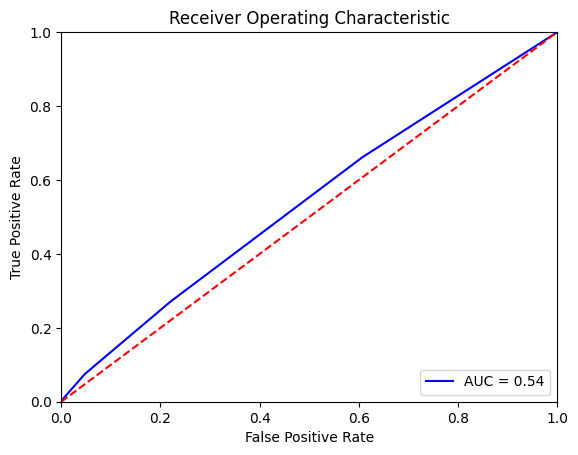

In [59]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)

y_pred_proba = KNN.predict_proba(x_test)

print('Bewertungsmetriken')
print('#'*20)
print(f"Bewertung der Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {round(KNN.score(x_train, y_train),2)}")
print(f"Bewertung der Vorhersage-Genauigkeit auf Basis der Testdaten: {round(KNN.score(x_test, y_test),2)}")
print('\n')
precision_train = round(precision_score(y_train,KNN.predict(x_train),zero_division=1.0,average='weighted'),2)
precision_test = round(precision_score(y_test,KNN.predict(x_test),zero_division=1.0,average='weighted'),2)
print(f"Precision auf Basis der Trainingsdaten: {precision_train}")
print(f"Precision auf Basis der Testdaten: {precision_test}")
print('\n')
auc_visualisierung(KNN,x_test,y_test)

## 2.4 Support Vektor Machine